# 1. Exploratory Data Analysis

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
data_folder = "data"
img_shape = 28, 28
nb_classes = 26

dataset_name = "sample-dataset.csv"

Lisons le jeu de données et examinons sa shape.

In [3]:
df = pd.read_csv(f"{data_folder}/{dataset_name}", header=None)

In [4]:
print(f"Il y a {df.shape[0]} lignes et {df.shape[1]} colonnes")

(3000, 785)

In [5]:
X = df.iloc[:, 1:]
y = df.iloc[:, 0]

In [6]:
print(f"{X.shape = }\n{y.shape = }")

X.shape =(3000, 784)
y.shape =(3000,)


/home/ab2/.cache/pypoetry/virtualenvs/m2-bhLFaoX6-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ab2/.cache/pypoetry/virtualenvs/m2-bhLFaoX6-py3.10/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='0', ylabel='Count'>

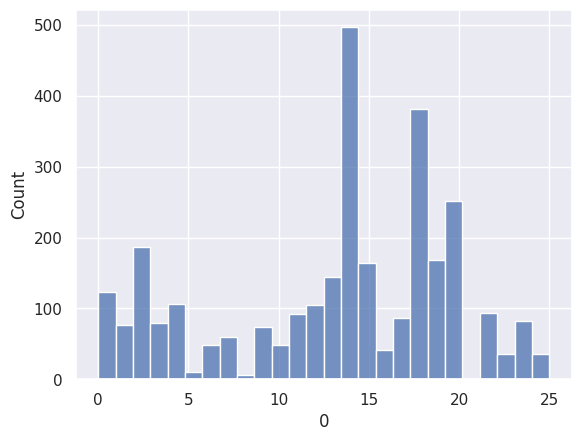

In [7]:
sns.histplot(df[0], bins=nb_classes)
plt.title("Répartition des classes")
plt.xlabel("classe (place dans l'alphabet - 1)")
plt.ylabel("occurrences")

Les classes ne sont pas tout à fait équilibrées, certaines sont quasiment absentes.

Affichons quelques images.

In [8]:
def plot_img(df: pd.DataFrame, index: int) -> None:
    plt.figure(figsize=(1, 1))
    img = np.array(df)[index].reshape(img_shape)
    plt.imshow(img)
    plt.show()

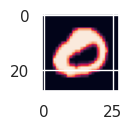

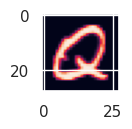

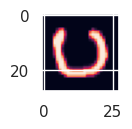

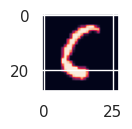

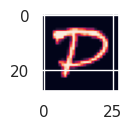

In [9]:
for i in range(5):
    plot_img(X, i)